In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import numpy as np

## Overview
- Positional encoding
- Attention
- Mask attention
- Single self attention head
- Multi-head attention
- Block
- Final mini project

### Positional Embedding :
Its actually an identity of the position.
Requirements of positional embeddings : 
- Position identifiers must be the same irrespective to the length of the sequence
- Trade off between semantic similatiy and positions

Frequency based positional encoding :


![My Image](https://miro.medium.com/v2/resize:fit:1044/1*fX8TN02pB5G1pLNsJIC6QA.png)

In [3]:
def pos_encoding(t, channels):
    inv_freq = 1.0 / (
        10000**(torch.arange(0, channels, 2, device=t.device).float()/channels)
    )
    pos_encoding_evn = torch.sin(t.repeat(channels//2, 1).permute(1,0)*inv_freq)
    pos_encoding_odd = torch.cos(t.repeat(channels//2, 1).permute(1,0)*inv_freq)
    pos_enc = torch.stack([pos_encoding_evn,pos_encoding_odd], dim=-1).reshape((pos_encoding_odd.shape[0], -1))
    return pos_enc

In [14]:
pos = torch.arange(0,4000)
print(pos)
pos = pos_encoding(pos,100)

tensor([    0,     1,     2,  ..., 39997, 39998, 39999])


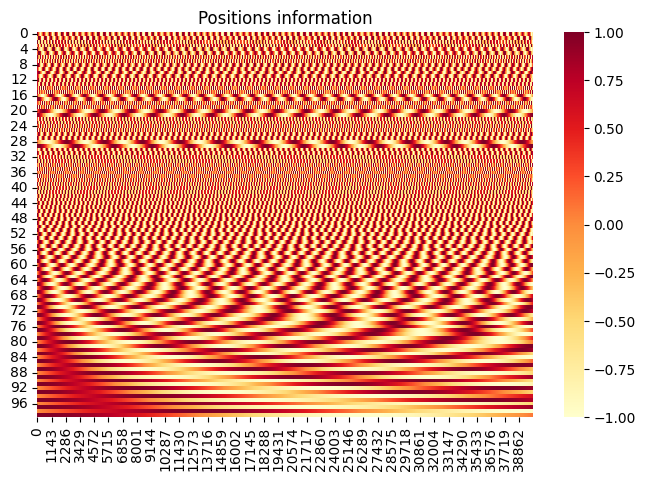

In [18]:
plt.figure(figsize=(8, 5))
sns.heatmap(pos.permute(1,0).numpy(), cmap='YlOrRd')
plt.title('Positions information')
plt.show()


### Attention

In [5]:
def attention(value,key,query):
    #                   query, key
    sim = torch.einsum("ble, bte->blt", query, key)
    scaled_sim = F.softmax(sim, dim=2)
    #                      scaled_sim, value
    out_put = torch.einsum('blt, bte ->ble', scaled_sim, value)
    return out_put

In [6]:
seq = torch.randn((3,10,8))
res = attention(seq,seq,seq)
res.shape

torch.Size([3, 10, 8])

### Mask attention

Creating the mask matrix based on its input

In [7]:
def attention(value,key,query, mask=False):
    device = query.device
    #                   query, key
    sim = torch.einsum("ble, bte->blt", query, key)
    if mask :
        mask = torch.tril(torch.ones(query.shape[-2], query.shape[-2], device=device))
    scaled_sim = F.softmax(sim, dim=2)
    #                      scaled_sim, value
    out_put = torch.einsum('blt, bte ->ble', scaled_sim, value)
    return mask

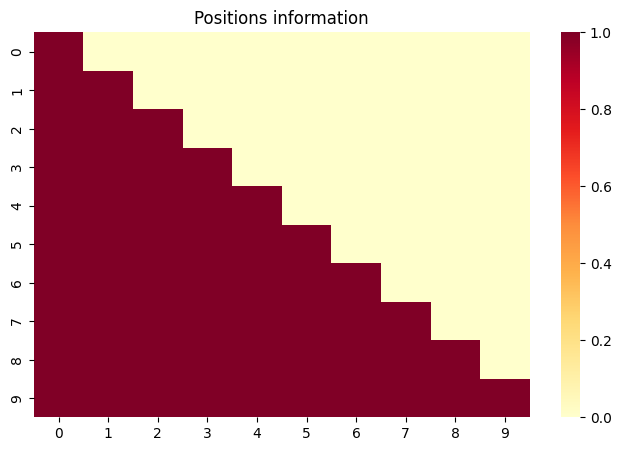

In [8]:
seq = torch.randn((1,10,8))
res = attention(seq,seq,seq, True)

plt.figure(figsize=(8, 5))
sns.heatmap(res.numpy(), cmap='YlOrRd')
plt.title('Positions information')
plt.show()

Masking the similarity matrix

In [9]:
def attention(value,key,query, mask=False):
    device = query.device
    #                   query, key
    sim = torch.einsum("ble, bte->blt", query, key)
    if mask :
        mask = torch.tril(torch.ones(query.shape[-2], query.shape[-2], device=device))
        sim = sim.masked_fill(mask==0, float('-inf'))

    scaled_sim = F.softmax(sim, dim=2)
    #                      scaled_sim, value
    out_put = torch.einsum('blt, bte ->ble', scaled_sim, value)
    return sim

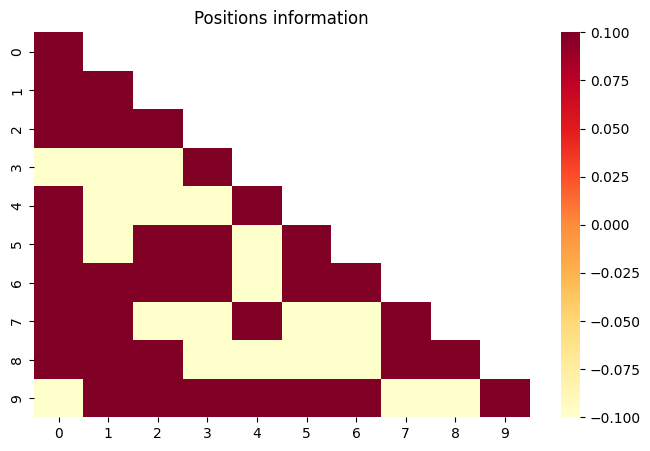

In [10]:
seq = torch.randn((1,10,8))
res = attention(seq,seq,seq, True)

plt.figure(figsize=(8, 5))
sns.heatmap(res.squeeze(0).numpy(), cmap='YlOrRd')
plt.title('Positions information')
plt.show()

In [19]:
def attention(value,key,query, mask=False):
    device = query.device
    #                   query, key
    sim = torch.einsum("ble, bte->blt", query, key)
    if mask :
        mask = torch.tril(torch.ones(query.shape[-2], query.shape[-2], device=device))
        sim = sim.masked_fill(mask==0, float('-inf'))

    scaled_sim = F.softmax(sim, dim=2)
    #                      scaled_sim, value
    out_put = torch.einsum('blt, bte ->ble', scaled_sim, value)
    return out_put

In [20]:
seq = torch.randn((7,10,8))
res = attention(seq,seq,seq, True)
res.shape

torch.Size([7, 10, 8])

### Single self attention head

In [21]:
def attention(value,key,query, mask=False):
    device = query.device
    #                   query, key
    sim = torch.einsum("ble, bte->blt", query, key)/(query.shape[-1]**(1/2))
    if mask :
        mask = torch.tril(torch.ones(query.shape[-2], query.shape[-2], device=device))
        sim = sim.masked_fill(mask==0, float('-inf'))

    scaled_sim = F.softmax(sim, dim=2)
    #                      scaled_sim, value
    out_put = torch.einsum('blt, bte ->ble', scaled_sim, value)
    return out_put

In [22]:
class head(nn.Module):
    def __init__(self, embed_size, head_size, mask=False):
        super().__init__()
        self.query_embd = nn.Linear(embed_size, head_size)
        self.key_embd = nn.Linear(embed_size, head_size)
        self.value_embd = nn.Linear(embed_size, head_size)
        self.mask = mask
    
    def forward(self, x):
        query = self.query_embd(x)
        key = self.key_embd(x)
        value = self.value_embd(x)
        result = attention(value, key, query, self.mask)
        return result

In [23]:
seq = torch.randn((4,50,32))
hed = head(32, 16,True)
res = hed(seq)
res.shape

torch.Size([4, 50, 16])

Dive into deep learning 
https://d2l.ai/index.html

### Multi-head attention
![Multi-head attention](https://wikidocs.net/images/page/159310/mha_img_original.png)


![Multi head](https://wikidocs.net/images/page/159310/mha_visualization-930x1030.png)

In [26]:
class multi_head(nn.Module):
    def __init__(self, embed_size, head_size, num_heads, mask=False):
        super().__init__()
        self.heads = nn.ModuleList([head(embed_size, head_size, mask) for _ in range(num_heads)])
        self.fc = nn.Linear(num_heads*head_size, embed_size)

    def forward(self, x):
        res = torch.cat([hd(x) for hd in self.heads], dim=-1)
        return self.fc(res)

In [27]:
seq = torch.randn((4,50,32))
multi_hd = multi_head(32, 16, 8,True)
res = multi_hd(seq)
res.shape

torch.Size([4, 50, 32])

![Transformer architecture](https://wikidocs.net/images/page/162098/0_transformer_attention.png)

### Block 

In [28]:
class block(nn.Module):
    def __init__(self, embed_size, head_size, num_heads, hidden_size, mask=True) :
        super().__init__()
        self.multiHead = multi_head(embed_size, head_size, num_heads, mask)
        self.ln1 = nn.LayerNorm(embed_size)
        self.fc = nn.Sequential(
            nn.Linear(embed_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, embed_size),
            nn.ReLU()
        )
        self.ln2 = nn.LayerNorm(embed_size)
        
    def forward(self, x):
        h = self.multiHead(x) + x 
        c = self.ln1(h)
        z = self.fc(c) + c
        return self.ln2(z)

In [29]:
seq = torch.randn((4,50,32))
encoderblock = block(32, 16, 8, 10)
res = encoderblock(seq)
res.shape

torch.Size([4, 50, 32])

---
---
### Mini project

In [20]:
data = pd.read_csv("15min_XAUUSD.csv")
data

,time,open,high,low,close,tick_volume,spread,real_volume
0,1549539900,1306.37,1306.54,1305.78,1305.90,250,21,0
1,1549539900,1306.37,1306.54,1305.78,1305.90,250,21,0
2,1549539900,1306.37,1306.54,1305.78,1305.90,250,21,0
3,1549539900,1306.37,1306.54,1305.78,1305.90,250,21,0
4,1549539900,1306.37,1306.54,1305.78,1305.90,250,21,0
...,...,...,...,...,...,...,...,...
99939,1683326700,2018.52,2018.86,2017.42,2017.66,1691,7,0
99940,1683327600,2017.69,2018.89,2017.25,2017.53,604,11,0
99941,1683328500,2017.55,2017.67,2016.89,2017.64,384,12,0
99942,1683329400,2017.62,2017.82,2015.89,2016.45,423,20,0


In [21]:
data = data.drop(["time","tick_volume", "spread", "real_volume"],axis=1)
data

,open,high,low,close
0,1306.37,1306.54,1305.78,1305.90
1,1306.37,1306.54,1305.78,1305.90
2,1306.37,1306.54,1305.78,1305.90
3,1306.37,1306.54,1305.78,1305.90
4,1306.37,1306.54,1305.78,1305.90
...,...,...,...,...
99939,2018.52,2018.86,2017.42,2017.66
99940,2017.69,2018.89,2017.25,2017.53
99941,2017.55,2017.67,2016.89,2017.64
99942,2017.62,2017.82,2015.89,2016.45


In [22]:
features = torch.tensor(data.iloc[:-1].values)
target = torch.tensor(data["close"].shift(-1).iloc[:-1].values)

In [23]:
features.shape ,target.shape

(torch.Size([99943, 4]), torch.Size([99943]))

In [24]:
lookback_window = 70

num_features = 4
output_size = 1 
embed_size = 128
head_size = 32
num_heads = 4
hidden_size = 32
num_blocks = 8

batch_size = 256
split_ratio = 0.8 
lr = 1e-5
epochs = 40

In [25]:
class xauusd_ds(Dataset):
    def __init__(self, features, target, lookback) :
        super().__init__()
        self.features = features
        self.target = target
        self.lookback = lookback
    
    def __len__(self):
        return self.features.shape[0] - self.lookback 
    
    def __getitem__(self, idx):
        x = self.features[idx:idx + self.lookback]
        y = self.target[idx:idx + self.lookback]
        return x, y

In [26]:
split_indx = int(len(features)*split_ratio)

train_ds = xauusd_ds(features[:split_indx], target[:split_indx], lookback_window)
test_ds = xauusd_ds(features[split_indx:], target[split_indx:], lookback_window)

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [27]:
def train(model, train_dl, loss_module, optimizer, epochs, device):
    model.train()
    train_loss = []
    pbar = tqdm(range(epochs))
    for epoch in pbar:
        ep_loss = 0
        for x, y in train_dl:
            x = x.to(device).to(torch.float32)
            y = y.to(device).to(torch.float32)

            y_pred = model(x).squeeze(-1)

            loss = loss_module(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            ep_loss += loss.item()
        ep_loss = ep_loss/len(train_dl)
        pbar.set_description(f"Epoch [{epoch}] :: Loss [{ep_loss}]")
        train_loss.append(ep_loss)
    return model, train_loss

In [28]:
@torch.no_grad()
def eval(model, test_dl, loss_module, device):
    model.eval()
    test_loss = 0
    pbar = tqdm(test_dl)
    for x, y in pbar:
        x = x.to(device).to(torch.float32)
        y = y.to(device).to(torch.float32)

        y_pred = model(x).squeeze(-1)

        loss = loss_module(y_pred, y)

        test_loss += loss.item()
    test_loss = test_loss/len(test_dl)
    return test_loss

In [29]:
class decoder(nn.Module):
    def __init__(self, num_features, out_size, embed_size, head_size, num_heads, hidden_size, num_blocks):
        super().__init__()
        self.embed_size = embed_size
        self.embeding = nn.Linear(num_features, embed_size)
        self.blocks = nn.Sequential(*[block(embed_size, head_size, num_heads, hidden_size) for _ in range(num_blocks)])
        self.fc = nn.Linear(embed_size, out_size)
        
    def forward(self, x):
        L = x.shape[1]
        device = x.device
        positions = pos_encoding(torch.arange(0,L, device=device), self.embed_size)
        h = self.embeding(x) + positions
        res = self.blocks(h)
        return self.fc(res)
    
class decoder_(nn.Module):
    def __init__(self, num_features, out_size, window_size, embed_size, head_size, num_heads, hidden_size, num_blocks):
        super().__init__()
        self.embed_size = embed_size
        self.position_embedding = nn.Embedding(window_size, embed_size) 
        self.embeding = nn.Linear(num_features, embed_size)
        self.blocks = nn.Sequential(*[block(embed_size, head_size, num_heads, hidden_size) for _ in range(num_blocks)])
        self.fc = nn.Linear(embed_size, out_size)
        
    def forward(self, x):
        L = x.shape[1]
        positions = self.position_embedding(torch.arange(L,device=x.device))
        h = self.embeding(x) + positions
        res = self.blocks(h)
        return self.fc(res)

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [31]:
# model = decoder(num_features, output_size, embed_size, head_size, num_heads, hidden_size, num_blocks).to(device)
model = decoder_(num_features, output_size, lookback_window, embed_size, head_size, num_heads, hidden_size, num_blocks).to(device)

In [32]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_module = nn.L1Loss()

In [33]:
model, train_loss = train(model, train_dl, loss_module, optimizer, epochs, device)

  0%|          | 0/40 [00:00<?, ?it/s]

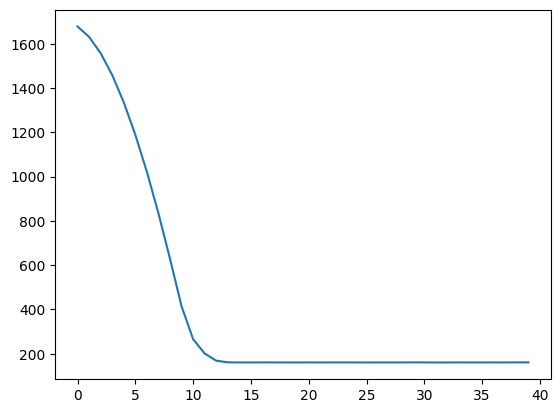

In [ ]:
plt.plot(train_loss)

In [ ]:
eval(model, test_dl, loss_module, device)

  0%|          | 0/78 [00:00<?, ?it/s]

92.25924664277296

In [ ]:
@torch.no_grad()
def predict(model, dl, device):
    model.eval()
    true_close = []
    predicted_close = []
    for x, y in tqdm(dl):
        x = x.to(device).to(torch.float32)
    
        y_pred = model(x).squeeze(-1).cpu()
        true_close.append(y[:,-1].numpy())
        predicted_close.append(y_pred[:,-1].numpy())
    
    true_close = np.concatenate(true_close, axis=0).reshape(-1)
    predicted_close = np.concatenate(predicted_close, axis=0).reshape(-1)
    return true_close, predicted_close

In [ ]:
true_close, predicted_close = predict(model, test_dl, device)

  0%|          | 0/78 [00:00<?, ?it/s]

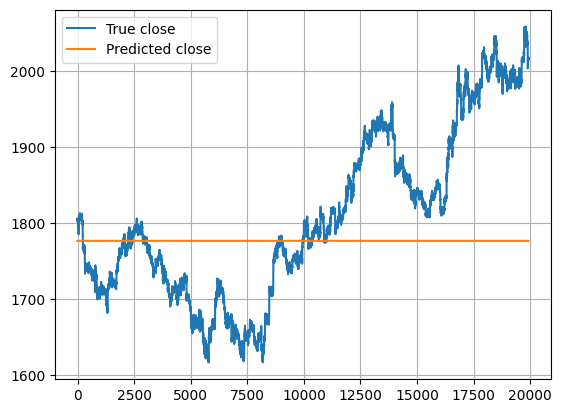

In [ ]:
plt.plot(true_close, label="True close")
plt.plot(predicted_close[:], label="Predicted close")
plt.legend()
plt.grid(True)